In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10) # Last two digits of student ID (10)

# Reinforcement Learning and Dynamic Optimization - Assignment 2



# Environment setting


The implementation was evaluated and found to incorporate the key elements of the multiplicative weights (MW) algorithm for the pricing problem with partial feedback. A base price is drawn uniformly from the interval [1.5, 2.5], and five pricing options are generated using the formulas:

• p₀ = α² · P

• p₁ = α · P

• p₂ = P

• p₃ = β · P

• p₄ = β² · P

with α = 0.5 and β = 1.5. The learning rate was set as η = √(ln(k) / T) and the exploration parameter as ε = T^(-1/3), which is a standard choice to ensure sublinear regret.

The raw probability distribution p is computed by normalizing the weights, and then a mixed distribution q is formed using q = (1 - ε)p + ε/k. This ensures that every arm is sampled with a minimum probability, which is essential in the bandit setting to control variance when applying importance sampling.

In each round, one arm is sampled according to q, and the corresponding price is offered. The user behavior is simulated so that the user picks the offered price with a probability of 50%. When the service is chosen, a reward equal to the offered price is obtained; otherwise, no reward is earned.

The loss is defined such that lower loss corresponds to higher profit. When the user selects the service, the loss is set to 1 minus the normalized reward (with normalization achieved by dividing the reward by the maximum possible price p4). When the competitor is chosen, a full loss of 1 is assigned. To obtain an unbiased estimate of the loss, importance sampling is applied by dividing the observed loss by the probability q of the chosen arm.

The weight for the chosen arm is then updated multiplicatively using the discount factor (1 - η) raised to the power of the estimated loss. The weights for the other arms remain unchanged in that round.

Bookkeeping is performed to track the evolution of the raw probabilities, the chosen arms, and the profits. These metrics are later used to plot the cumulative profit, the average profit per round, and the evolution of the pricing policy over time.

It is noted that the algorithm does not update the weights of the arms that are not selected because only the loss for the chosen arm is observed. The use of the mixed probability distribution q (rather than p alone) is intended to prevent extremely low selection probabilities, which would otherwise lead to high variance in the importance sampling estimates.


# Q1 - Naive user

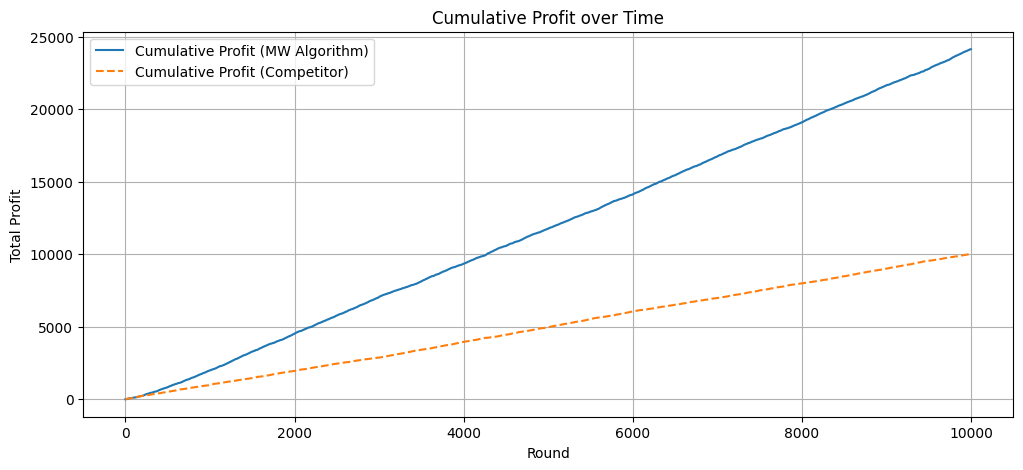

Fig 1.1: Cumulative Profit over Time




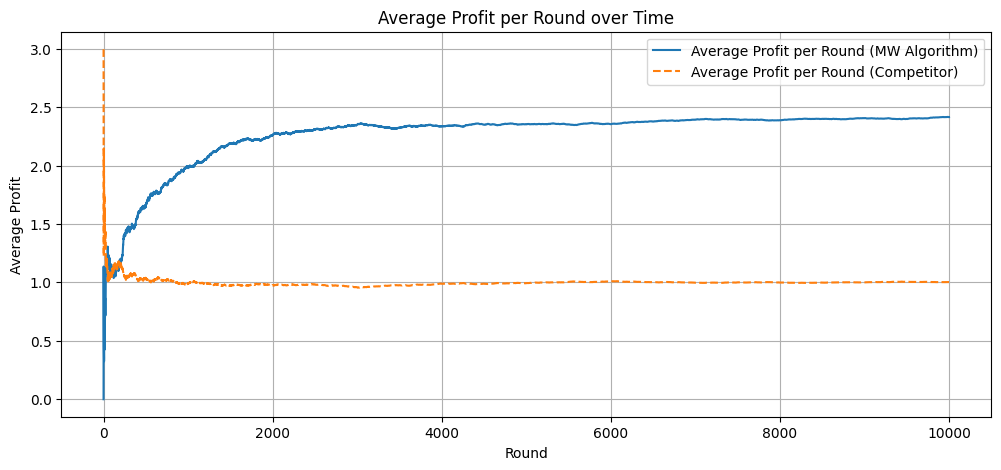

Fig 1.2: Average Profit per Round over Time




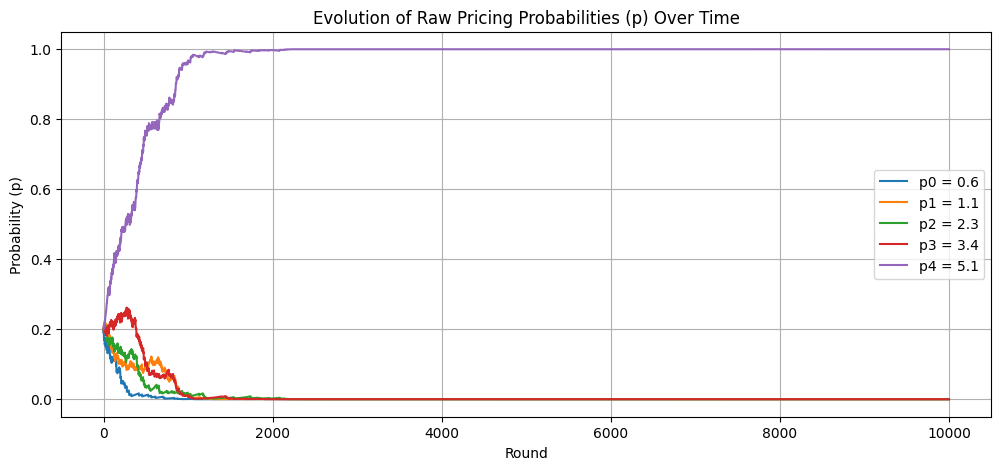

Fig 1.3: Evolution of Raw Pricing Probabilities (p) Over Time




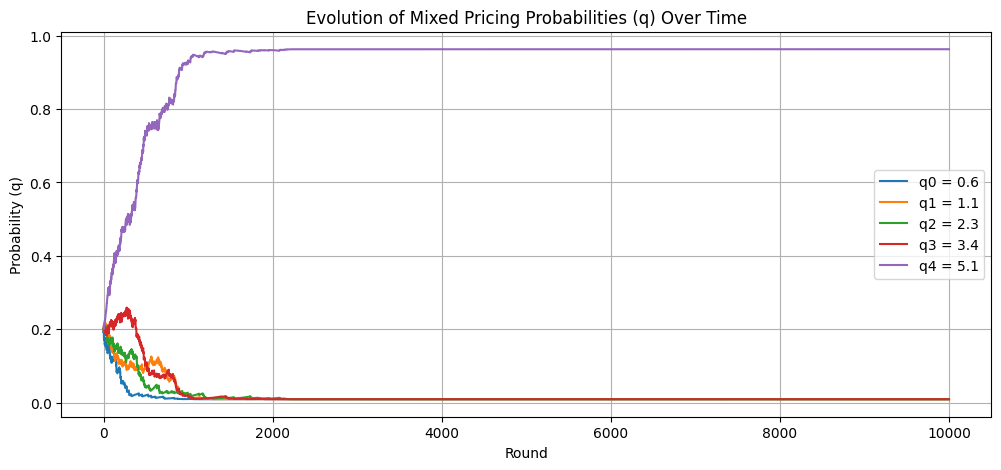

Fig 1.4: Evolution of Mixed Pricing Probabilities (q) Over Time




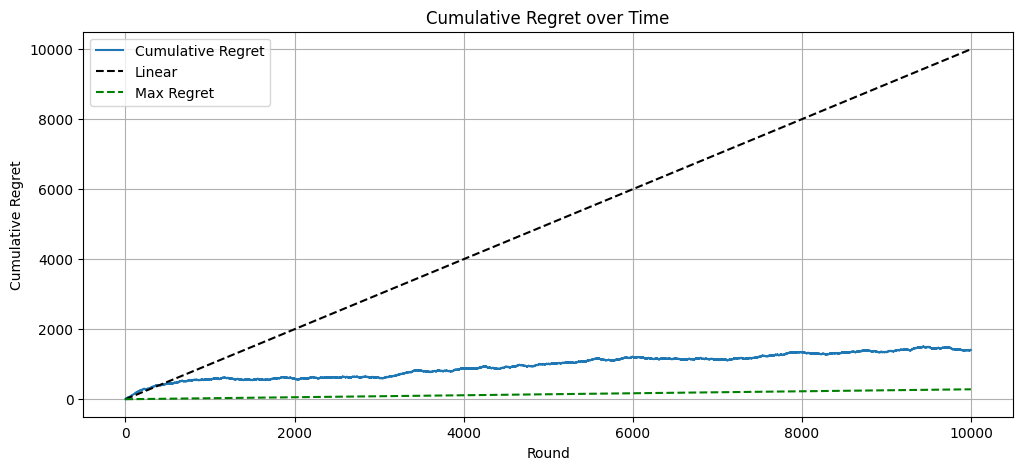

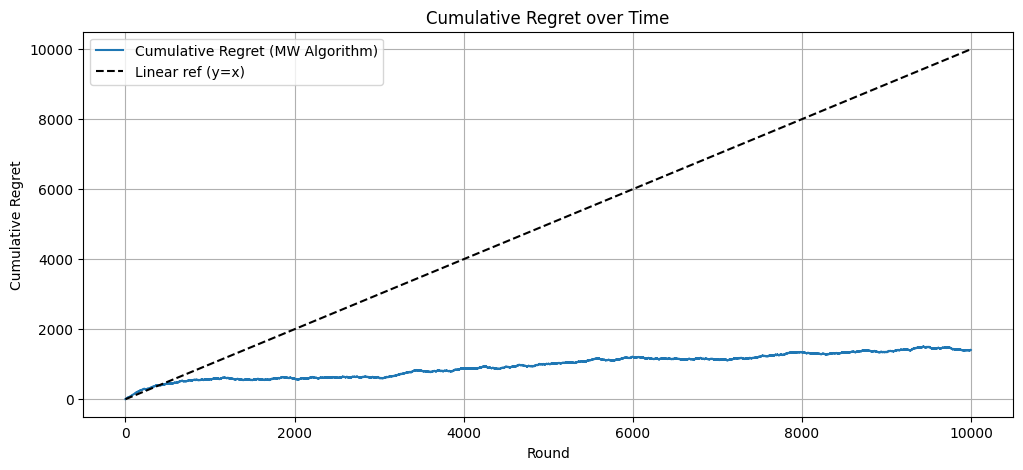

Fig 1.5: Cumulative Regret over Time




In [41]:
# Multiplicative Weights Pricing Algorithm (Q1)

# Student ID last two digits: 10
np.random.seed(10)

# --- Constants and Parameters ---
T = 10000                            # Number of rounds
alpha, beta = 0.5, 1.5
k = 5                                 # Number of arms (price options)
P = np.random.uniform(1.5, 2.5)       # Base price
prices = [alpha**2 * P, alpha * P, P, beta * P, beta**2 * P]
# p0 = 0.25 * P, p1 = 0.5 * P, p2 = P, p3 = 1.5 * P, p4 = 2.25 * P


# MW/bandits Parameters
eta = np.sqrt(np.log(k) / T)          # Learning rate
epsilon = T**(-1/3)                   # Exploration parameter
w = np.ones(k)                        # Initial weights assigned to 1

# Tracking metrics
probs = []                           # Raw probability distribution (p)
q_list = []                          # Mixed distribution (q)
chosen_arms = []
profits = []                         # Profit from MW
average_profits = []

competitor_profits = []              # Profit from competitor
average_competitor_profits = []

# --- MW Loop ---
for t in range(T):
    W = np.sum(w)
    p = w / W
    q = (1 - epsilon) * p + epsilon / k

    i = np.random.choice(k, p=q)
    price = prices[i]

    if np.random.rand() < 0.5:
        reward = price
        competitor_reward = 0
    else:
        reward = 0
        competitor_reward = np.random.uniform(0, 4)

    rho = prices[-1]
    if reward > 0:
        normalized_reward = reward / rho
        loss = 1 - normalized_reward
    else:
        loss = 1

    estimated_loss = loss / q[i]
    w[i] *= (1 - eta) ** estimated_loss

    probs.append(p)
    q_list.append(q)
    chosen_arms.append(i)
    profits.append(reward)
    average_profits.append(np.mean(profits))

    competitor_profits.append(competitor_reward)
    average_competitor_profits.append(np.mean(competitor_profits))

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(profits), label='Cumulative Profit (MW Algorithm)')
plt.plot(np.cumsum(competitor_profits), label='Cumulative Profit (Competitor)', linestyle='--')
plt.xlabel('Round')
plt.ylabel('Total Profit')
plt.title('Cumulative Profit over Time')
plt.grid(True)
plt.legend()
plt.show()

print("Fig 1.1: Cumulative Profit over Time\n\n")

plt.figure(figsize=(12, 5))
plt.plot(average_profits, label='Average Profit per Round (MW Algorithm)')
plt.plot(average_competitor_profits, label='Average Profit per Round (Competitor)', linestyle='--')
plt.xlabel('Round')
plt.ylabel('Average Profit')
plt.title('Average Profit per Round over Time')
plt.grid(True)
plt.legend()
plt.show()

print("Fig 1.2: Average Profit per Round over Time\n\n")

plt.figure(figsize=(12, 5))
for i in range(k):
    freq = [p[i] for p in probs]
    plt.plot(freq, label=f'p{i} = {prices[i]:.1f}')
plt.xlabel('Round')
plt.ylabel('Probability (p)')
plt.title('Evolution of Raw Pricing Probabilities (p) Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 1.3: Evolution of Raw Pricing Probabilities (p) Over Time\n\n")

plt.figure(figsize=(12, 5))
for i in range(k):
    freq_q = [q[i] for q in q_list]
    plt.plot(freq_q, label=f'q{i} = {prices[i]:.1f}')
plt.xlabel('Round')
plt.ylabel('Probability (q)')
plt.title('Evolution of Mixed Pricing Probabilities (q) Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 1.4: Evolution of Mixed Pricing Probabilities (q) Over Time\n\n")



# Regret analysis vs. optimal fixed price (always choose the highest price)
best_price = prices[-1]
# Optimal profit per round for our algorithm would be 0.5 * best_price (50% chance when chosen)
optimal_profit_per_round = 0.5 * best_price
optimal_cumulative_profit = np.arange(1, T + 1) * optimal_profit_per_round

mw_cumulative_profit = np.cumsum(profits)
regret = optimal_cumulative_profit - mw_cumulative_profit

plt.figure(figsize=(12, 5))
plt.plot(regret, label='Cumulative Regret (MW Algorithm)')

# Plot a linear baseline (y = x) to illustrate that the regret grows sublinearly
plt.plot([0, T], [0, T], 'k--', label='Linear ref (y=x)')

# # Theoretical upper bound for MW in adversarial bandits (ignoring constants): O(sqrt(T * n * ln(n)))
# theoretical_bound = np.sqrt(T * n * np.log(n))
# plt.plot([0, T], [0, theoretical_bound], 'g--', label=r'Theoretical $O(\sqrt{T\,n\ln n})$')

plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time')
plt.legend()
plt.grid(True)
plt.show()


print("Fig 1.5: Cumulative Regret over Time\n\n")


##Q1 Findings

### Fig 1.1: Cumulative Profit over Time

This plot compares the cumulative profit of the Multiplicative Weights (MW) algorithm to that of a baseline competitor using uniform random pricing. Over 10,000 rounds, we observe that the MW algorithm significantly outperforms the competitor. While the competitor achieves an expected cumulative profit close to 10,000 (due to being chosen with 50% probability and offering uniformly random prices in [0, 4], yielding an expected profit of 0.5 × 2 = 1 per round), the MW algorithm surpasses 24,000 in cumulative profit. This is because MW learns to favor higher prices that maximize profit under the user's naive (random) choice behavior. Losses are normalized and minimized more effectively when higher price arms are selected, leading to higher weights and selection probability over time. This illustrates MW’s ability to learn and adapt in an adversarial bandit setting with partial observability.<br/><br/>

### Fig 1.2: Average Profit per Round over Time

This plot illustrates how the average profit evolves for both the MW algorithm and the competitor across time. Initially, both strategies experience volatility: the competitor's average profit spikes above 3 due to random chance, while MW dips toward 0 due to early exploratory missteps. However, over time, the competitor stabilizes around an average profit of ~1, consistent with being chosen 50% of the time and offering uniformly drawn prices from [0, 4]. In contrast, the MW algorithm steadily improves and converges to an average profit of approximately 2.4 per round. This is expected given that the algorithm learns to favor higher prices (e.g., 5.11), which yield higher rewards. The MW strategy thus demonstrates effective learning, refining its pricing policy toward the most profitable options.<br/><br/>

### Fig 1.3 & Fig 1.4: Evolution of Raw (p) and Mixed (q) Pricing Probabilities (p) Over Time

Figures 1.3 and 1.4 depict, respectively, the evolution of the raw pricing probabilities 𝑝 and the mixed probabilities 𝑞 over time. Initially, the algorithm allocates probability mass nearly uniformly across all pricing arms, reflecting a phase of broad exploration. However, by around 1000 rounds, the probability mass becomes almost entirely concentrated on the highest-priced arm (approximately 𝑝4=5.11), while the probabilities for the other arms fall to near zero. The similarity between the 𝑝 and 𝑞 plots is due to the small exploration parameter (with $ \epsilon = T^{-1/3} \approx 0.046 $), which results in only a minor deviation of 𝑞 from 𝑝. These results demonstrate that the MW algorithm effectively learns to favor the most profitable pricing option, thereby converging to a nearly deterministic policy. It should be noted that a higher exploration parameter or a shorter time horizon would result in a more pronounced exploration phase, but in this instance, the long horizon and modest $\epsilon$ drive the rapid concentration on the optimal arm.<br/><br/>



### Fig 1.5: Cumulative Regreat over Time

This plot shows the cumulative regret of the MW algorithm compared to the optimal fixed strategy of always choosing the highest price arm. The regret curve grows slowly and clearly stays below a linear baseline (shown with a dashed $ y = x $ reference line), indicating sublinear growth. This confirms that our MW algorithm is learning effectively and adapting to the naive user behavior. <br/><br/>


### A more general remark
In the current setting, the environment is relatively naive because both the user and the competitor are non-adaptive—the user selects randomly, and the competitor’s prices are drawn randomly from a fixed distribution. This makes the problem more tractable than a truly adversarial one. In a fully adversarial setting, the competitor or environment could adapt its behavior each round to specifically counteract the MW algorithm. For example, an adversary could monitor the pricing strategy of the MW algorithm and deliberately set its own prices or adjust the losses in a way that forces the algorithm to incur higher regret. Such an adversarial scenario would be significantly more challenging, as the algorithm would have to contend with an opponent that actively tries to outsmart it rather than just random chance.





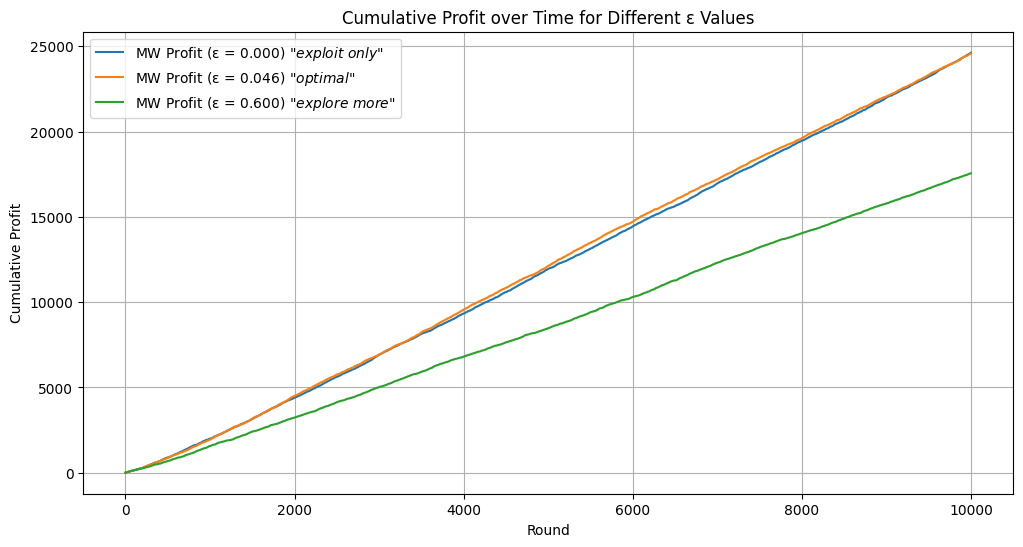

Fig 1.6: Cumulative Profit over Time for Different ε Values




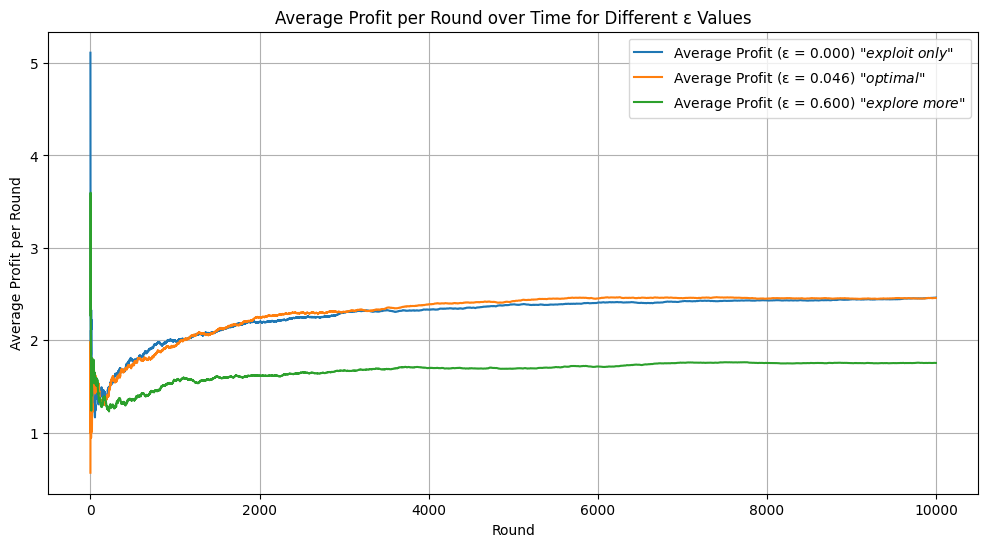

Fig 1.7: Average Profit per Round over Time for Different ε Values




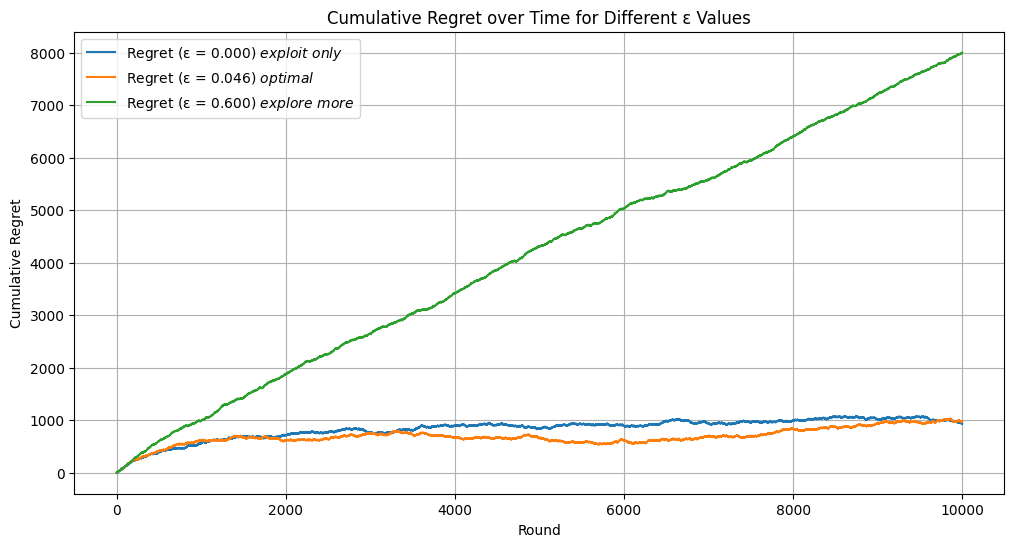

Fig 1.8: Cumulative Regret over Time for Different ε Values




In [42]:
# Sensitivity to epsilon
eta = np.sqrt(np.log(k) / T)
epsilon_values = [0, T**(-1/3), 0.6]
results = {}

for epsilon in epsilon_values:
    w = np.ones(k)
    cum_profit = []
    avg_profit = []
    profits = []
    competitor_profits = []
    cumulative_profit = 0
    for t in range(T):
        W = np.sum(w)
        p = w / W
        q = (1 - epsilon) * p + epsilon / k if epsilon > 0 else p.copy()

        i = np.random.choice(k, p=q)
        price = prices[i]
        if np.random.rand() < 0.5:
            reward = price
            competitor_reward = 0
        else:
            reward = 0
            competitor_reward = np.random.uniform(0, 4)

        rho = prices[-1]
        if reward > 0:
            normalized_reward = reward / rho
            loss = 1 - normalized_reward
        else:
            loss = 1

        estimated_loss = loss / q[i]
        w[i] *= (1 - eta) ** estimated_loss

        profits.append(reward)
        competitor_profits.append(competitor_reward)
        cumulative_profit += reward
        cum_profit.append(cumulative_profit)
        avg_profit.append(np.mean(profits))

    results[epsilon] = {
        'cumulative_profit': np.array(cum_profit),
        'average_profit': np.array(avg_profit),
        'competitor_cumulative_profit': np.cumsum(competitor_profits)
    }

# Cumulative profit comparison
plt.figure(figsize=(12, 6))
plt.plot(results[epsilon_values[0]]['cumulative_profit'], label=f'MW Profit (ε = {epsilon_values[0]:.3f}) "$\it{{exploit\ only}}$"')
plt.plot(results[epsilon_values[1]]['cumulative_profit'], label=f'MW Profit (ε = {epsilon_values[1]:.3f}) "$\it{{optimal}}$"')
plt.plot(results[epsilon_values[2]]['cumulative_profit'], label=f'MW Profit (ε = {epsilon_values[2]:.3f}) "$\it{{explore\ more}}$"')

plt.xlabel('Round')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit over Time for Different ε Values')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 1.6: Cumulative Profit over Time for Different ε Values\n\n")

# Average profit per round
plt.figure(figsize=(12, 6))
plt.plot(results[epsilon_values[0]]['average_profit'], label=f'Average Profit (ε = {epsilon_values[0]:.3f}) "$\it{{exploit\ only}}$"')
plt.plot(results[epsilon_values[1]]['average_profit'], label=f'Average Profit (ε = {epsilon_values[1]:.3f}) "$\it{{optimal}}$"')
plt.plot(results[epsilon_values[2]]['average_profit'], label=f'Average Profit (ε = {epsilon_values[2]:.3f}) "$\it{{explore\ more}}$"')

plt.xlabel('Round')
plt.ylabel('Average Profit per Round')
plt.title('Average Profit per Round over Time for Different ε Values')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 1.7: Average Profit per Round over Time for Different ε Values\n\n")

# Regret comparison
optimal_profit = np.arange(1, T + 1) * 0.5 * best_price
plt.figure(figsize=(12, 6))
labels = {
    epsilon_values[0]: "$\it{exploit\ only}$",
    epsilon_values[1]: "$\it{optimal}$",
    epsilon_values[2]: "$\it{explore\ more}$"
}

for eps in epsilon_values:
    regret = optimal_profit - results[eps]['cumulative_profit']
    plt.plot(regret, label=f'Regret (ε = {eps:.3f}) {labels[eps]}')

plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time for Different ε Values')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 1.8: Cumulative Regret over Time for Different ε Values\n\n")

## Sensitivity Analysis of $\epsilon$ — Exploration vs Exploitation

In this section, we investigate how the exploration parameter $ \epsilon $ affects the performance of the MW algorithm. We compare three configurations:
- $\epsilon = 0.0 $: a greedy, exploit-only strategy with no forced exploration
- $ \epsilon = 0.046 $: the theoretically grounded optimal choice $ \epsilon = T^{-1/3}$
- $ \epsilon = 0.6 $: a heavily exploratory setup

**Fig 1.6** shows that both the optimal and exploit-only configurations yield high cumulative profit, with the exploit-only slightly outperforming. In contrast, the high-exploration setup underperforms due to over-sampling suboptimal arms, which is unnecessary in this naive-user scenario where the best arm quickly becomes evident.

**Fig 1.7** confirms this trend for average profit per round. Both the exploit-only and optimal $ \epsilon$ settle around 2.5, while the exploratory setup lags at around 1.8. The excessive exploration prevents the algorithm from focusing on the best arm consistently.

**Fig 1.8** displays the cumulative regret. While all curves are sublinear, the regret for $ \epsilon = 0.6 $ approaches 8000—much worse than the $ \sim1000 $ seen for the other two cases. This reinforces the point that in environments with clear optimal arms and simple user behavior, minimal exploration is sufficient is this naive setup.


# Q2 - Smart after T/4 user

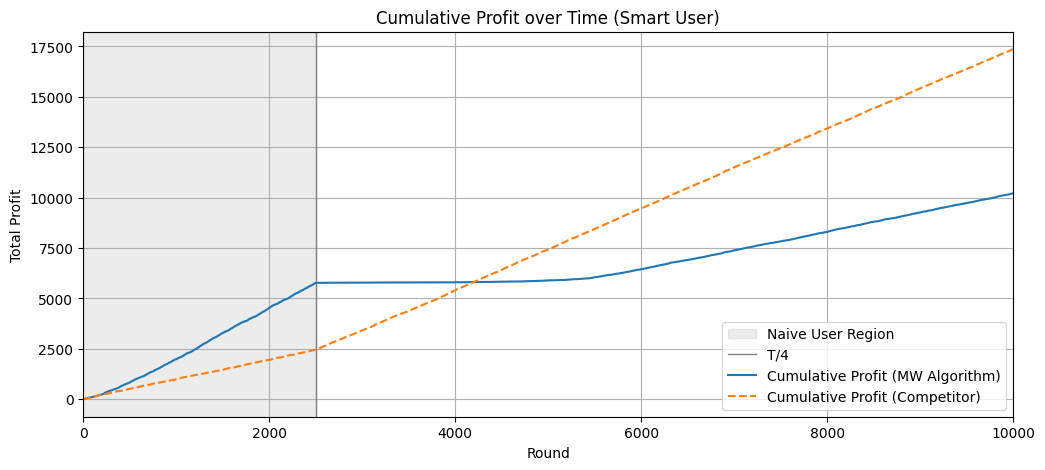

Fig 2.1: Cumulative Profit over Time (Smart User)




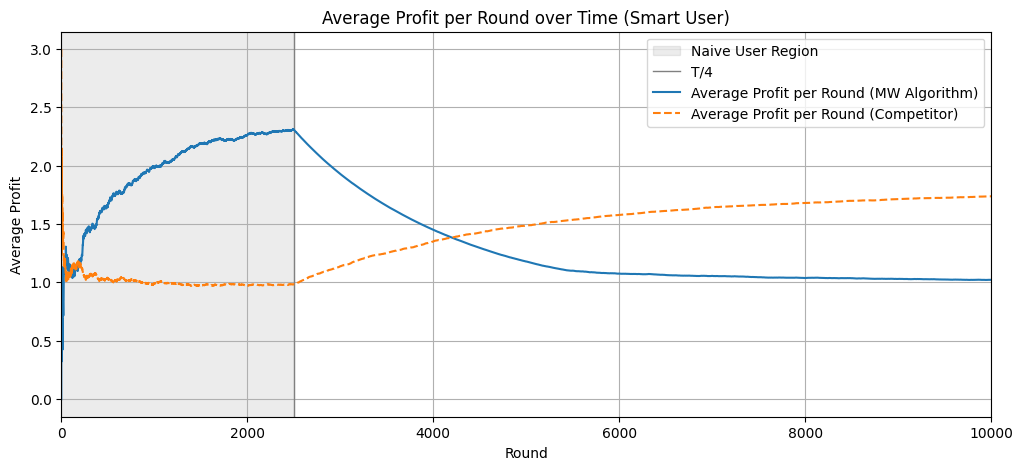

Fig 2.2: Average Profit per Round over Time (Smart User)




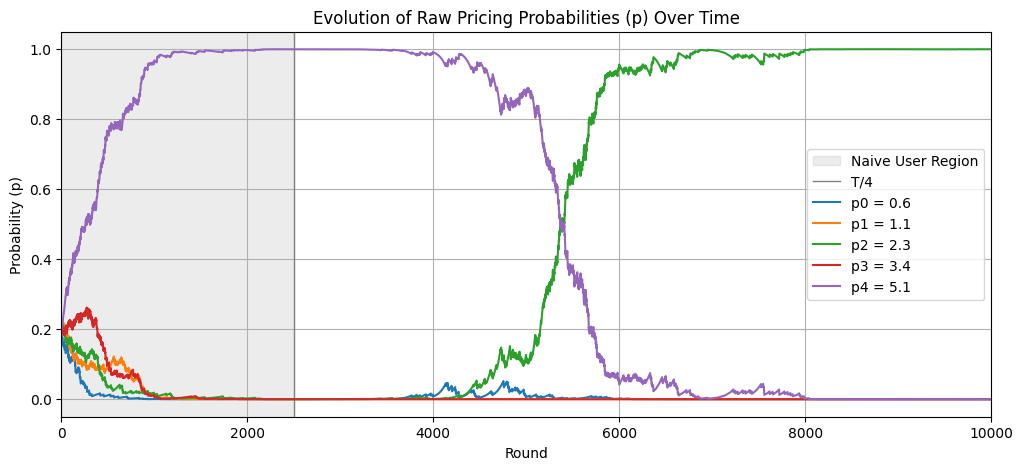

Fig 2.3: Evolution of Raw Pricing Probabilities (p) Over Time (Smart User)




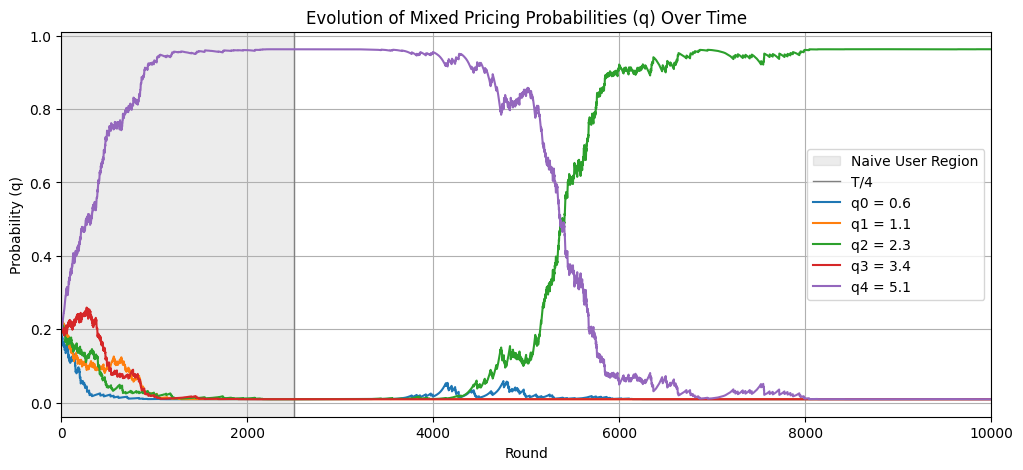

Fig 2.4: Evolution of Mixed Pricing Probabilities (q) Over Time (Smart User)




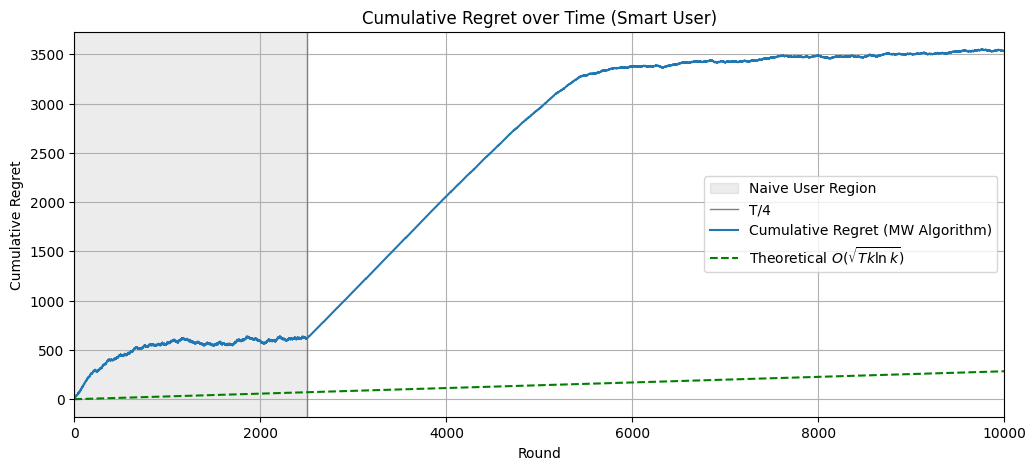

Fig 2.5: Cumulative Regret over Time




In [101]:
np.random.seed(10)  # Last two digits of student ID (10)

# --- Constants and Parameters ---
T = 10000                      # Total number of rounds
alpha, beta = 0.5, 1.5
k = 5                                 # Number of arms (price options)
P = np.random.uniform(1.5, 2.5)         # Base price drawn uniformly from [1.5, 2.5]
prices = [alpha**2 * P, alpha * P, P, beta * P, beta**2 * P]
# p0 = 0.25 * P, p1 = 0.5 * P, p2 = P, p3 = 1.5 * P, p4 = 2.25 * P
#prices[2] = 2.1
#prices = [1.8, 1.9, 2.0, 2.3, 2.5]


# MW/Bandits Parameters
eta = np.sqrt(np.log(k) / T)          # Learning rate for sublinear regret
#eta = 0.5
epsilon = T**(-1/3)                   # Exploration parameter
#epsilon = 0.1
w = np.ones(k)                        # Initial weights

# Tracking metrics
probs = []                           # Raw probability distribution (p)
q_list = []                          # Mixed distribution (q)
chosen_arms = []
profits = []                         # Profit from MW algorithm
average_profits = []

competitor_profits = []              # Profit from competitor
average_competitor_profits = []

# --- MW Loop ---
for t in range(T):
    W = np.sum(w)
    p = w / W
    q = (1 - epsilon) * p + epsilon / k

    i = np.random.choice(k, p=q)
    price = prices[i]

    # Simulate user behavior:
    # For t < T/4: Naive user (randomly chooses between you and competitor)
    # For t >= T/4: Smart user (compares both prices and chooses the lower one)
    if t < T / 4:
        if np.random.rand() < 0.5:
            reward = price
            competitor_reward = 0
        else:
            reward = 0
            competitor_reward = np.random.uniform(0, 4)
    else:
        competitor_price = np.random.uniform(0, 4)
        if price < competitor_price:
            reward = price
            competitor_reward = competitor_price
        else:
            reward = 0
            competitor_reward = competitor_price

    # Loss calculation with normalization:
    # Use the highest price (p4) as the upper bound (rho)
    rho = prices[-1]
    if reward > 0:
        normalized_reward = reward / rho
        loss = 1 - normalized_reward  # Lower loss for higher profit
    else:
        loss = 1  # Full loss if not chosen

    # Importance sampling: scale the loss by the inverse of the mixed probability
    estimated_loss = loss / q[i]

    # MW update: update only the chosen arm's weight
    w[i] *= (1 - eta) ** estimated_loss

    # Bookkeeping
    probs.append(p)
    q_list.append(q)
    chosen_arms.append(i)
    profits.append(reward)
    average_profits.append(np.mean(profits))
    competitor_profits.append(competitor_reward)
    average_competitor_profits.append(np.mean(competitor_profits))


# Plot: Cumulative Profit over Time for MW Algorithm vs. Competitor
plt.figure(figsize=(12, 5))
plt.axvspan(0, T/4, color='gray', alpha=0.15, label='Naive User Region')
plt.axvline(x=T/4, color='gray', linestyle='-', label='T/4', linewidth=1)
plt.plot(np.cumsum(profits), label='Cumulative Profit (MW Algorithm)')
plt.plot(np.cumsum(competitor_profits), label='Cumulative Profit (Competitor)', linestyle='--')
plt.xlim(0, T)
plt.xlabel('Round')
plt.ylabel('Total Profit')
plt.title('Cumulative Profit over Time (Smart User)')
plt.grid(True)
plt.legend()
plt.show()

print("Fig 2.1: Cumulative Profit over Time (Smart User)\n\n")


# Plot: Average Profit per Round over Time
plt.figure(figsize=(12, 5))
plt.axvspan(0, T/4, color='gray', alpha=0.15, label='Naive User Region')
plt.axvline(x=T/4, color='gray', linestyle='-', label='T/4', linewidth=1)
plt.plot(average_profits, label='Average Profit per Round (MW Algorithm)')
plt.plot(average_competitor_profits, label='Average Profit per Round (Competitor)', linestyle='--')
plt.xlim(0, T)
plt.xlabel('Round')
plt.ylabel('Average Profit')
plt.title('Average Profit per Round over Time (Smart User)')
plt.grid(True)
plt.legend()
plt.show()

print("Fig 2.2: Average Profit per Round over Time (Smart User)\n\n")

plt.figure(figsize=(12, 5))
plt.axvspan(0, T/4, color='gray', alpha=0.15, label='Naive User Region')
plt.axvline(x=T/4, color='gray', linestyle='-', label='T/4', linewidth=1)
for i in range(k):
    freq = [p[i] for p in probs]
    plt.plot(freq, label=f'p{i} = {prices[i]:.1f}')
plt.xlim(0, T)
plt.xlabel('Round')
plt.ylabel('Probability (p)')
plt.title('Evolution of Raw Pricing Probabilities (p) Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 2.3: Evolution of Raw Pricing Probabilities (p) Over Time (Smart User)\n\n")



plt.figure(figsize=(12, 5))
plt.axvspan(0, T/4, color='gray', alpha=0.15, label='Naive User Region')
plt.axvline(x=T/4, color='gray', linestyle='-', label='T/4', linewidth=1)
for i in range(k):
    freq_q = [q[i] for q in q_list]
    plt.plot(freq_q, label=f'q{i} = {prices[i]:.1f}')
plt.xlabel('Round')
plt.xlim(0, T)
plt.ylabel('Probability (q)')
plt.title('Evolution of Mixed Pricing Probabilities (q) Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 2.4: Evolution of Mixed Pricing Probabilities (q) Over Time (Smart User)\n\n")



# # Regret analysis vs. optimal fixed price (always choose the highest price)
# best_price = prices[-1]
# # Optimal profit per round for our algorithm would be 0.5 * best_price (50% chance when chosen)
# optimal_profit_per_round = 0.5 * best_price
# optimal_cumulative_profit = np.arange(1, T + 1) * optimal_profit_per_round

# mw_cumulative_profit = np.cumsum(profits)
# regret = optimal_cumulative_profit - mw_cumulative_profit

# plt.figure(figsize=(12, 5))
# plt.axvspan(0, T/4, color='gray', alpha=0.15, label='Naive User Region')
# plt.axvline(x=T/4, color='gray', linestyle='-', label='T/4', linewidth=1)
# plt.plot(regret, label='Cumulative Regret (MW Algorithm)')
# # Plot a linear baseline (y = x) to illustrate that the regret grows sublinearly
# plt.plot([0, T], [0, T], 'k--', label='Linear ref (y=x)')
# plt.xlim(0, T)
# # # Theoretical upper bound for MW in adversarial bandits (ignoring constants): O(sqrt(T * n * ln(n)))
# # theoretical_bound = np.sqrt(T * n * np.log(n))
# # plt.plot([0, T], [0, theoretical_bound], 'g--', label=r'Theoretical $O(\sqrt{T\,n\ln n})$')
# plt.xlabel('Round')
# plt.ylabel('Cumulative Regret')
# plt.title('Cumulative Regret over Time')
# plt.legend()
# plt.grid(True)
# plt.show()


# --- Regret Analysis for Smart User (Updated) ---

# Phase-specific optimal strategies:
# Naive user: best to offer highest price (p4), win prob = 0.5
naive_optimal = 0.5 * prices[-1]

# Smart user: best to offer a moderate price (e.g., p2), win prob = P(Q > p2) = (4 - p2) / 4
smart_price = prices[2]  # p2
smart_win_prob = (4 - smart_price) / 4
smart_optimal = smart_win_prob * smart_price

# Build piecewise optimal profit trajectory
optimal_profit = np.zeros(T)
optimal_profit[:T//4] = naive_optimal
optimal_profit[T//4:] = smart_optimal
optimal_cumulative_profit = np.cumsum(optimal_profit)

# Compute MW algorithm's regret
mw_cumulative_profit = np.cumsum(profits)
regret = optimal_cumulative_profit - mw_cumulative_profit

# Compute theoretical regret bound: O(sqrt(T * k * ln k))
regret_bound = np.sqrt(T * k * np.log(k))

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.axvspan(0, T/4, color='gray', alpha=0.15, label='Naive User Region')
plt.axvline(x=T/4, color='gray', linestyle='-', label='T/4', linewidth=1)
plt.plot(regret, label='Cumulative Regret (MW Algorithm)')
plt.plot([0, T], [0, regret_bound], 'g--', label=r'Theoretical $O(\sqrt{T k \ln k})$')
plt.xlim(0, T)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time (Smart User)')
plt.legend()
plt.grid(True)
plt.show()


print("Fig 2.5: Cumulative Regret over Time\n\n")

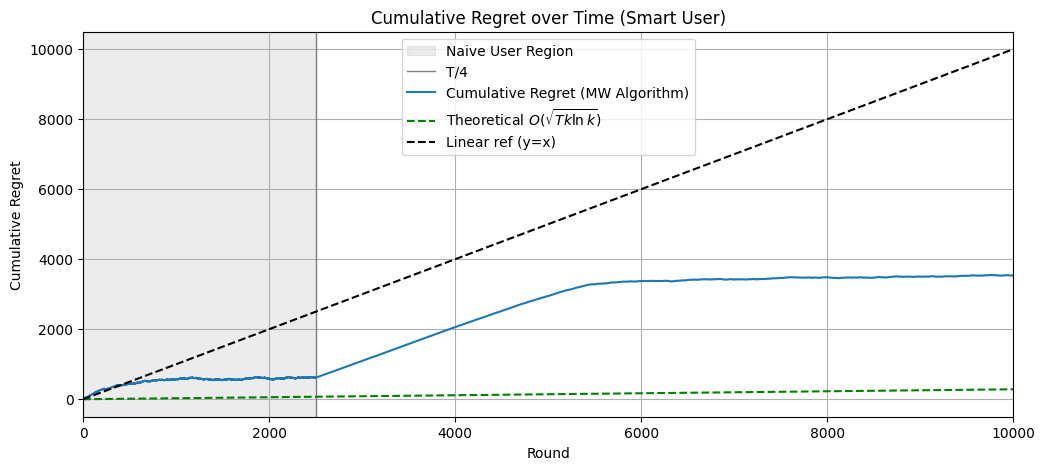

Fig 2.6 [updated]: Cumulative Regret over Time




In [103]:
# --- Regret Analysis for Smart User (Updated) ---

# Phase-specific optimal strategies:
# Naive user: best to offer highest price (p4), win prob = 0.5
naive_optimal = 0.5 * prices[-1]

# Smart user: best to offer a moderate price (e.g., p2), win prob = P(Q > p2) = (4 - p2) / 4
smart_price = prices[2]  # p2
smart_win_prob = (4 - smart_price) / 4
smart_optimal = smart_win_prob * smart_price

# Build piecewise optimal profit trajectory
optimal_profit = np.zeros(T)
optimal_profit[:T//4] = naive_optimal
optimal_profit[T//4:] = smart_optimal
optimal_cumulative_profit = np.cumsum(optimal_profit)

# Compute MW algorithm's regret
mw_cumulative_profit = np.cumsum(profits)
regret = optimal_cumulative_profit - mw_cumulative_profit

# Compute theoretical regret bound: O(sqrt(T * k * ln k))
regret_bound = np.sqrt(T * k * np.log(k))

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.axvspan(0, T/4, color='gray', alpha=0.15, label='Naive User Region')
plt.axvline(x=T/4, color='gray', linestyle='-', label='T/4', linewidth=1)
plt.plot(regret, label='Cumulative Regret (MW Algorithm)')
plt.plot([0, T], [0, regret_bound], 'g--', label=r'Theoretical $O(\sqrt{T k \ln k})$')
plt.plot([0, T], [0, T], 'k--', label='Linear ref (y=x)')

plt.xlim(0, T)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time (Smart User)')
plt.legend()
plt.grid(True)
plt.show()

print("Fig 2.6 [updated]: Cumulative Regret over Time\n\n")


## Q2 Findings

### Fig 2.1: Cumulative Profit over Time (Smart User)

This plot highlights how the MW algorithm performs when the user's behavior shifts from **naive** to **smart** at round $T/4$. In the **naive phase** (shaded region), MW quickly learns to select the highest-price arm $p_4$, leading to **fast-growing cumulative profit**. Since users choose sellers at random, the algorithm's strategy of offering expensive prices yields high returns and clearly outpaces the uniformly random competitor. However, once users become **smart** (i.e., they choose the lowest price), the MW algorithm **initially fails to adapt**. The previously favored high-priced arm is now almost never selected, leading to nearly **zero profit** for a long adjustment period (~2000 rounds). This stagnation is visible as a flat segment in the cumulative profit curve. Meanwhile, the **competitor**, although random, offers prices from a uniform distribution over $[0, 4]$. This means that a significant fraction of the time it ends up offering lower prices than the MW algorithm, resulting in steadily increasing profit after $T/4$. Eventually, the competitor **surpasses MW in total profit**.<br/><br/>


### Fig 2.2: Average Profit per Round over Time (Smart User)

This plot provides insight into how the average profit per round evolves for both the MW algorithm and the competitor, especially across the user behavior transition at $T/4$. During the **naive phase**, the MW algorithm enjoys a rapid climb in average profit, peaking at around **2.4**. This is expected, as it learns to consistently select the most profitable (highest-price) arm while the user randomly picks a seller, giving the algorithm a 50% chance of earning that high price.

However, once the user becomes smart and starts selecting the **lower of the two offered prices**, the performance of the MW algorithm deteriorates significantly. It initially continues to propose high prices, but these are now consistently **rejected in favor of the competitor's lower price**, leading to prolonged zero-profit rounds. Over time, the algorithm does adapt, shifting toward more moderate prices, but this takes hundreds of rounds.

By the end of the time horizon, the **MW algorithm converges to an average profit of about 1.0**, while the **competitor converges to a significantly higher value, approximately 1.75**. This difference is noteworthy and raises several points:

- The **competitor samples from a continuous uniform distribution in $[0, 4]$**, giving it a fine-grained and stochastic advantage in undercutting the MW algorithm's fixed-price strategy.
- The MW algorithm selects from a **discrete set of only 5 fixed prices**, making it more predictable and less flexible in offering lower prices that can consistently beat the competitor.
- The **highest price** available to the MW algorithm is around **$5.1$**, which **will always be rejected** in the smart-user phase, since the competitor never bids more than $4$.

Therefore, the competitor has an **inherent structural advantage** in the smart-user regime: its continuous randomness provides a better chance of winning price comparisons, even if it is not explicitly learning. The MW algorithm, while powerful in learning from feedback, is constrained by its fixed action space and slower adaptation. This highlights the challenge of competing against even a "dumb" but randomized strategy when faced with strategic user behavior and limited pricing granularity.<br/><br/>

### Fig 2.3 & Fig 2.4: Evolution of Raw (p) and Mixed (q) Pricing Probabilities (p) Over Time (Smart User)

**Fig 2.3** (Raw probabilities) and **Fig 2.4** (Mixed probabilities) visualize how the algorithm adapts to a change in user behavior at round $T/4$.

Initially, during the naive user phase, the MW algorithm quickly learns to favor the highest price arm $p_4 \approx 5.1$, since users choose sellers uniformly at random. In this setting, maximizing the offered price also maximizes the expected profit — thus, MW aggressively increases the weight of $p_4$.

However, once the user becomes **smart** and begins to compare prices before deciding, this strategy collapses: the high-priced arm is no longer selected, yielding zero profit and thus incurring **maximum loss (1.0)**. As a result, the MW algorithm starts to **penalize** $p_4$ and reduce its weight drastically.

In response, the probability of $p_2 \approx 2.3$ rises steadily. This price is **not the lowest**, but often beats the competitor's randomly drawn price (from a uniform distribution $Q \sim \text{Unif}[0, 4]$), while still ensuring decent revenue when selected.

This transition reflects the MW algorithm’s sensitivity to shifts in environment: even without being told that user behavior has changed, it learns to adjust its pricing policy based solely on partial bandit feedback. It shifts from an exploitative high-pricing strategy to a more competitive, profit-preserving one — demonstrating the algorithm’s adaptive power.<br/><br/>





### Fig 2.5: Cumulative Regreat over Time (Smart User)

This figure visualizes the cumulative regret of the MW algorithm compared to a piecewise optimal policy that accounts for the **regime switch** at $T/4$. Initially, during the **naive user phase**, the optimal strategy is to offer the highest price, since the user chooses randomly. In the **smart phase**, however, users select the cheapest price, making the optimal strategy a balance between pricing low enough to win, but high enough to make a profit (here, $p_2 = 2.3$ approximates that tradeoff).

We observe that regret grows slowly at first, but then **spikes** shortly after the transition point. This is due to the **non-stationary environment**: the MW algorithm must unlearn its previous belief that high prices are optimal and adapt to the new regime. This delay in readjusting leads to a burst of regret accumulation.

Two key factors exacerbate this:

- **Mismatch Between Loss Design and Environment**: The loss function used by the MW algorithm continues to reward higher prices due to its naive-phase calibration. After the regime switch, however, users now prefer **lower prices**. This misalignment in incentives causes the algorithm to stick with suboptimal pricing longer than desired.

- **Competitor’s Stochastic Behavior**: Although the competitor uses a uniform random policy over $[0, 4]$, this randomness becomes an advantage in the smart user regime. It frequently undercuts the MW algorithm, winning more customers. The MW algorithm, trying to adapt, may shift toward lower prices—yet these may be too low to yield good profits, leading to poor performance even when it starts to "win."

Finally, we plot a theoretical $O(\sqrt{T k \ln k})$ regret bound as a reference. While the MW regret curve eventually levels off, it remains above the bound, highlighting that the **adaptation delay and environmental shift** impose extra regret that is not accounted for by the standard theoretical bound, which assumes a stationary adversarial setting.


<br/><br/>


